In [72]:
%matplotlib inline
from collections import defaultdict
import pymc3 as pm
from pymc3 import traceplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId

## Data

### Fetching the data

In [2]:
client = MongoClient()
db = client.heroku_rnwkcq9r

In [3]:
def question_text(question_id):
    question = db.question.find_one({'_id': question_id})
    return question['text']

In [4]:
def question_max_value(question_id):
    question = db.question.find_one({'_id': question_id})
    if question['question_type'] == "boolean":
        return 1
    elif question["question_type"] == "numerical":
        if 'numericalAnswers' in question:
            max_value = max(map(int,question['numericalAnswers'].keys()))
            return max_value
        else:
            return 5

In [5]:
def answer_value(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    q_id = answer['question']
    if 'numerical_answer' in answer:
        return answer['numerical_answer'] / float(question_max_value(q_id))
    elif 'boolean_answer' in answer:
        return answer['boolean_answer'] / float(question_max_value(q_id))

In [6]:
def answer_with_score(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    return 'text_answer' not in answer

In [7]:
def score_handin_grader(handin_id,grader_id):
    # find all answers to the hand in of the grader and average it out
    report_grade = db.report_grade.find_one({'handin': handin_id, 'giver': grader_id})
    answers = db.answer.find({'report_grade': report_grade['_id'] })
    handin_acc = 0.0
    for answer in answers:
        if answer_with_score(answer['_id']):
            handin_acc = handin_acc + answer_value(answer['_id'])
    return handin_acc / float(answers.count())

In [8]:
def score_handin_list(handin_id):
    scores = list()
    report_grades = db.report_grade.find({'handin': handin_id, 'state': 'ANSWERED'})
    for report_grade in report_grades:
        scores.append((score_handin_grader(handin_id,report_grade['giver']),report_grade['giver']))
    return scores

In [9]:
# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def assignment_handins(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append((score_handin_list(handin['_id']),handin['_id']))
    return handins_reports

In [10]:
def grader_ids(assignment_id):
    graders = set()
    report_grades = db.report_grade.find({'assignment':assignment_id})
    for report_grade in report_grades:
        graders.add(report_grade['giver'])
    return list(graders)

In [11]:
def grader_name(grader_id):
    grader = db.user.find_one({'_id': grader_id})
    return grader['name']

In [12]:
def course_handins(course_id):
    handins = list()
    assignments = db.assignment.find({'course':course_id})
    for assignment in assignments:
        handins.extend(assignment_handins(assignment['_id']))
    return handins

## Models

In [105]:
data = [(0.2726495726495726, ObjectId('55e4330ded7a0c0009f0d9d9')),
 (0.6410256410256411, ObjectId('55f2d136d8786100099ff332')),
 (0.5128205128205128, ObjectId('55db3833edf3950009412132')),
 (0.46153846153846156, ObjectId('55e59e8336cc7d00092c414a')),
 (0.6410256410256411, ObjectId('55d9cb9ea6fb8f00080da473')),
 (0.6153846153846154, ObjectId('55db3833edf395000941213d')),
 (0.4871794871794871, ObjectId('56056a8689c698000f9c29bd')),
 (0.9957264957264957, ObjectId('55db3832edf395000941211a'))]

In [106]:
data = map(lambda x: x[0],data)

In [107]:
with pm.Model() as s_model:
    N = len(data)

    # True score
    T_mu = pm.Uniform('T_mu',0,1)
    T = pm.Normal('T', mu=T_mu, tau=100, testval = np.mean(data))

    # Bias
    B = list()
    O = list()

    for i in range(0, N):
        B.append(pm.Normal('B_%i' % i, mu=0, tau=100, testval=0))
        O.append(pm.Normal('O_%i' % i, mu = T + B[i], tau=100, observed=data[i]))

    distr = [T_mu, T]
    distr.extend(B)
    distr.extend(O)
    step = pm.NUTS(distr)

Applied interval-transform to T_mu and added transformed T_mu_interval to model.


In [129]:
with s_model:
    start = pm.find_MAP()
    mcmc = pm.sample(2000, step, start=start)

 [-----------------100%-----------------] 2000 of 2000 complete in 4.6 sec

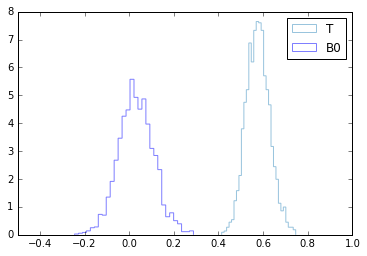

In [130]:
T = mcmc["T"][:]
plt.hist(T, histtype="step", normed=True, alpha=0.5, bins=30,
         label="T", color="#348ABD")
B0 = mcmc["B_1"][:]
plt.hist(B0, histtype="step", normed=True, alpha=0.5, bins=30,
         label="B0")
plt.xlim(-0.5,1)
plt.legend()
plt.show()

In [131]:
print "The mean value of the observed data:"
print np.mean(data_)
print "The expected value of the normal distribution of T, the true score:"
print np.mean(T)
print "The expected value of the normal distribution of the bias of the first grader B0:"
print data_[1]
print np.mean(B0)

The mean value of the observed data:
0.578418803419
The expected value of the normal distribution of T, the true score:
0.576961830239
The expected value of the normal distribution of the bias of the first grader B0:
0.641025641026
0.031423559304


In [132]:
data = course_handins(ObjectId("55d9cb9ea6fb8f00080da4a1"))

In [ ]:
with pm.Model() as c_model:
    N_H = len(data)

    # Bias
    T_mu = list()
    T = dict()
    B = dict()
    O = list()

    for h in range(0, N_H):
        (scores,h_id) = data[h]
        N_G = len(scores)

        T_temp = pm.Uniform('T_mu_%s' % str(h_id),lower=0,upper=1,testval = np.mean(map(lambda x:x[0],scores)))
        T_mu.append(T_temp)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=100, testval = np.mean(map(lambda x:x[0],scores)))

        for g in range(0, N_G):
            (val,g_id) = scores[g]
            if g_id not in B:
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=0, tau=100)
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=val))

    distr = T_mu[:]
    distr.extend(T.values())
    distr.extend(B.values())
    distr.extend(O.values)
    step = pm.NUTS(distr)        

Applied interval-transform to T_mu_5608e19c898536000fe40a19 and added transformed T_mu_5608e19c898536000fe40a19_interval to model.
Applied interval-transform to T_mu_560902a2898536000fe40a1c and added transformed T_mu_560902a2898536000fe40a1c_interval to model.
Applied interval-transform to T_mu_560931317d3cd2000f66db2c and added transformed T_mu_560931317d3cd2000f66db2c_interval to model.
Applied interval-transform to T_mu_560933f47d3cd2000f66db2d and added transformed T_mu_560933f47d3cd2000f66db2d_interval to model.
Applied interval-transform to T_mu_560947ea1bd43a000fb1228c and added transformed T_mu_560947ea1bd43a000fb1228c_interval to model.
Applied interval-transform to T_mu_560948691bd43a000fb1228d and added transformed T_mu_560948691bd43a000fb1228d_interval to model.
Applied interval-transform to T_mu_560953571bd43a000fb12305 and added transformed T_mu_560953571bd43a000fb12305_interval to model.
Applied interval-transform to T_mu_56096f641bd43a000fb12306 and added transformed T

In [77]:
with c_model:
    start = pm.find_MAP()
    mcmc = pm.sample(2000, step, start=start)